In [1]:
import numpy as np
import time
import random
from unityagents import UnityEnvironment
from collections import namedtuple, deque
import torch
from torch import optim
from torch.nn import functional
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 0
if torch.cuda.is_available:
    torch.cuda.manual_seed(seed)  
torch.manual_seed(seed)

In [2]:
class DuelQNet(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden=[100,64,64,64,64], value=[64], advantage=[64]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int) : Dimension of each state
            action_size (int) : Dimension of each action
            seed (int) : Random seed
            hidden (list) : Number of neurons (int) in each hidden layer
            value (list) : State value
            advantage (list) : Advantages for each action
        """
        super(DuelQNet,self).__init__()    
        hidden = list(hidden)
        value = list(value)
        advantage = list(advantage)
        self.state_size = state_size
        self.action_size = action_size
        self.seed = torch.manual_seed(seed)
        self.input = nn.Linear(state_size, hidden[0])
        self.dropout = nn.Dropout(p = 0.3)
        self.hidden = nn.ModuleList([nn.Linear(hidden[t],hidden[t+1]) for t in range(len(hidden)-1)])
        value.insert(0, hidden[-1])
        value.append(1)
        self.value = nn.ModuleList([nn.Linear(value[t],value[t+1]) for t in range(len(value)-1)])
        advantage.insert(0,hidden[-1])
        advantage.append(action_size)
        self.advantage = nn.ModuleList([nn.Linear(advantage[t],advantage[t+1]) for t in range(len(advantage)-1)])
        
    def forward(self,state):
        s = state
        s = functional.relu(self.input(s))
        s = self.dropout(s)
        for layer in self.hidden:
            s = functional.relu(layer(s))
        adv = s
        
        for layer in self.advantage:
            adv = functional.relu(layer(adv)) if layer != self.advantage[-1] else layer(adv)
        val = s
        
        for layer in self.value:
            val = functional.relu(layer(val)) if layer != self.value[-1] else layer(val)
        
        return adv+val

In [3]:
class ExpBuffer:
    def __init__(self, batch_size = 128, buffer_size = 10000, min_delta=1e-5):
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.buffer = deque(maxlen=buffer_size)
        self.deltas = deque(maxlen=buffer_size)
        self.exp_template = namedtuple("exp", field_names=["state","action","reward","new_state","done"])
    
    def add(self, state, action, reward, new_state, done):
        exp = self.exp_template(state, action, reward, new_state, int(done))
        self.buffer.append(exp)
        self.deltas.append( max(self.deltas) if len(self.deltas) > 0 else self.min_delta )
    
    def sample(self,priority=0.5):
        deltas = np.array(self.deltas)
        probs = deltas**priority / np.sum(deltas**priority)
        exp_batch_idx = np.random.choice(np.arange(len(self.buffer)), size=self.batch_size, p=probs, replace=False)
        states = torch.from_numpy(np.vstack([self.buffer[idx].state for idx in exp_batch_idx])).float().to(device)
        actions = torch.from_numpy(np.vstack([self.buffer[idx].action for idx in exp_batch_idx])).long().to(device)
        rewards = torch.from_numpy(np.vstack([self.buffer[idx].reward for idx in exp_batch_idx])).float().to(device)
        new_states = torch.from_numpy(np.vstack([self.buffer[idx].new_state for idx in exp_batch_idx])).float().to(device)
        dones = torch.from_numpy(np.vstack([self.buffer[idx].done for idx in exp_batch_idx])).float().to(device)
        probabilities = torch.from_numpy(np.vstack([probs[idx] for idx in exp_batch_idx])).float().to(device)
        
        return states, actions, rewards, new_states, dones, probabilities, exp_batch_idx
    
    def update_deltas(self,idxs,deltas):
        for i,idx in enumerate(idxs):
            self.deltas[idx] = deltas[i] + self.min_delta
    
    def __len__(self):
        return len(self.buffer)


In [4]:
class Agent:
    def __init__(self, state_size, action_size, num_episodes, gamma=0.99, lr=5e-4, batch_size=64, learn_every=4, global_update_rate=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.learn_every = learn_every
        self.global_update_rate = global_update_rate
        self.seed = 0
        self.local_network = DuelQNet(state_size,action_size,self.seed).to(device)
        self.global_network = DuelQNet(state_size,action_size,self.seed).to(device)
        self.optimizer = optim.Adam(self.local_network.parameters(), lr=lr)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=num_episodes, eta_min=1e-10)
        
        self.experience_buffer = ExpBuffer(batch_size=self.batch_size)
        self.i_step = 0
        self.loss_list = []
        self.entropy_list = []
    
    def adjust_lr(self,episode):
        self.lr_scheduler.step(episode)
        return self.lr_scheduler.get_lr()[0]
    
    def step(self, state, action, reward, new_state, done, weight_importance=0.5, priority=0.5):
        self.experience_buffer.add(state, action, reward, new_state, done)
        self.i_step = ( self.i_step + 1 ) % self.learn_every
        if self.i_step == 0:
            if len(self.experience_buffer)>self.batch_size:
                exp_batch = self.experience_buffer.sample(priority)
                self.learn(exp_batch,weight_importance)
    
    def choose_action(self, state, epsilon=0.):
        rnd = random.random()
        if rnd < epsilon:
            return random.choice(np.arange(self.action_size))
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_network.eval()
        with torch.no_grad():
            action_values = self.local_network(state)
        self.local_network.train()
        return int(torch.argmax(action_values).cpu().numpy())
    
    def learn(self, exp_batch, weight_importance=0.5):
        states, actions, rewards, new_states, dones, probs, exp_idxs = exp_batch
        next_action_values_local = self.local_network(new_states).detach()
        next_best_action_idxs = torch.argmax(next_action_values_local,1)

        next_action_values = self.global_network(new_states).detach()
        Q_target_next = next_action_values.gather(1, next_best_action_idxs.unsqueeze(1))
        
        Q_targets = rewards + ( self.gamma * Q_target_next * (1-dones))
        
        predict = self.local_network(states)
        Q_current = predict.gather(1, actions)
    
        td_error = (Q_targets - Q_current)
        new_deltas = torch.abs(td_error.detach().squeeze(1)).cpu().numpy()
        self.experience_buffer.update_deltas(exp_idxs,new_deltas)
        
        self.optimizer.zero_grad()
        batch_loss = td_error ** 2
        weights = ( (1/len(self.experience_buffer)) * (1/probs) )**weight_importance
        loss = torch.mean(batch_loss * weights)
        loss.backward()
        self.loss_list.append(loss.item())
        self.optimizer.step()
        
        with torch.no_grad():
            self.entropy_list.append( functional.cross_entropy(predict,actions.squeeze(1)).cpu().numpy() )
        self.soft_update()
        
    def soft_update(self):
        tau = self.global_update_rate
        for local_params, global_params in zip(self.local_network.parameters(), self.global_network.parameters()):
            global_params.data.copy_( tau * local_params.data + (1-tau)*global_params.data )

## Training the Model 

In [5]:
env = UnityEnvironment(file_name="Banana.app");
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
num_episodes = 2000
max_t = 1000
agent = Agent(state_size, action_size, num_episodes)

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.99

print_step = 100
average_last_N=100
score_list = []
lr_list = []

eps = eps_start
pri = 0.5
wi = 0.5

last_saved_score = 0

session_ts = str(int(time.time()))

for i_episode in range(num_episodes):
    step_info = env.reset(train_mode=True)[brain_name]
    state = step_info.vector_observations[0]
    score = 0
    lr_list.append(agent.adjust_lr(i_episode))
    for i_step in range(max_t):
        action = agent.choose_action(state,eps)
        
        step_info = env.step(action)[brain_name]
        new_state = step_info.vector_observations[0]   
        reward = step_info.rewards[0]                    
        done = step_info.local_done[0]   
        agent.step(state,action,reward,new_state,done,wi,pri)
        
        score += reward
        state = new_state
        if done:
            score_list.append(score)
            break
    
    eps = max(eps_end, eps*eps_decay)
    pri = 0
    wi = 0
    
    if i_episode % print_step == 0:
        score_avg = np.average(score_list[-average_last_N:])
        entropy_avg = np.average(agent.entropy_list[-average_last_N:])
        loss_avg = np.average(agent.loss_list[-average_last_N:])
        last_lr = lr_list[-1]
        print(f"Episode: {i_episode}/{num_episodes}\tAvgScore: {score_avg:.2f}\tLoss: {loss_avg:.5f}\teps: {eps:.2f}\tlr: {last_lr:.3e}")
        if score_avg > 13 and score_avg > last_saved_score:
            last_saved_score = score_avg
            name = f"savedweights-ep{i_episode}-score{score_avg:.3f}.pth"
            print('Saved Model:', name)
            torch.save(agent.local_network.state_dict(), name)

Episode: 0/2000	AvgScore: -1.00	Loss: 0.00674	eps: 0.99	lr: 5.000e-04
Episode: 100/2000	AvgScore: 0.91	Loss: 0.01028	eps: 0.36	lr: 4.969e-04
Episode: 200/2000	AvgScore: 5.65	Loss: 0.01688	eps: 0.13	lr: 4.878e-04
Episode: 300/2000	AvgScore: 10.68	Loss: 0.02597	eps: 0.05	lr: 4.728e-04
Episode: 400/2000	AvgScore: 12.51	Loss: 0.02306	eps: 0.02	lr: 4.523e-04
Episode: 500/2000	AvgScore: 14.09	Loss: 0.02700	eps: 0.01	lr: 4.268e-04
Saved Model: savedweights-ep500-score14.090.pth
Episode: 600/2000	AvgScore: 15.11	Loss: 0.02792	eps: 0.01	lr: 3.969e-04
Saved Model: savedweights-ep600-score15.110.pth
Episode: 700/2000	AvgScore: 15.21	Loss: 0.03554	eps: 0.01	lr: 3.635e-04
Saved Model: savedweights-ep700-score15.210.pth
Episode: 800/2000	AvgScore: 14.37	Loss: 0.03650	eps: 0.01	lr: 3.273e-04
Episode: 900/2000	AvgScore: 15.82	Loss: 0.03870	eps: 0.01	lr: 2.891e-04
Saved Model: savedweights-ep900-score15.820.pth
Episode: 1000/2000	AvgScore: 15.25	Loss: 0.04269	eps: 0.01	lr: 2.500e-04
Episode: 1100/2000	

## Plotting Score vs Episode

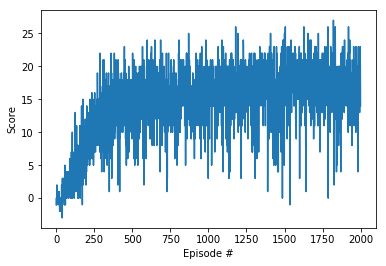

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(score_list)), score_list) 
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

